### General information

This kernel is intented to help mlcourse.ai participants with doing EDA, Feature Engineering and building models.

* At first I'll do basic EDA of the data;
* After this I'll build a baseline model to see how good model can be on the basic data;
* Then I'll create new features based on the main features and train a model again to see whether there is an improvement;
* After this I'll try to extract new features from json files and see whether it helps;

In [89]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import collections
import datetime
import json
import ast
import time
from scipy import stats
import os
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import metrics
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
import eli5
from eli5.sklearn import PermutationImportance
import shap
from tqdm import tqdm_notebook
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from catboost import CatBoostClassifier

# import json
import altair as alt
from  altair.vega import v3
from IPython.display import HTML

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
!pip install ujson
import ujson as json

import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

In [128]:

class ColumnDataProcessor:
    to_scale = True

    def replaceNaNValues(self, A):
        A[np.isnan(A)] = 0
        A[np.isinf(A)] = 0
        return A

    def add_feature_average(self, df, c, r_columns, d_columns):
        df['r_total_' + c] = df[r_columns].sum(1)
        df['d_total_' + c] = df[d_columns].sum(1)
        df['total_' + c + '_ratio'] = df['r_total_' + c] / df['d_total_' + c]
        df['total_' + c + '_ratio'] = self.replaceNaNValues(df['total_' + c + '_ratio'])

        df['r_std_' + c] = df[r_columns].std(1)
        df['d_std_' + c] = df[d_columns].std(1)
        df['std_' + c + '_ratio'] = df['r_std_' + c] / df['d_std_' + c]
        df['std_' + c + '_ratio'] = self.replaceNaNValues(df['std_' + c + '_ratio'])

        df['r_mean_' + c] = df[r_columns].mean(1)
        df['d_mean_' + c] = df[d_columns].mean(1)
        df['mean_' + c + '_ratio'] = df['r_mean_' + c] / df['d_mean_' + c]
        df['mean_' + c + '_ratio'] = self.replaceNaNValues(df['mean_' + c + '_ratio'])

        df = df.drop(r_columns, axis=1).reset_index(drop=True)
        df = df.drop(d_columns, axis=1).reset_index(drop=True)
        df = df.drop(
            ['r_total_' + c, 'd_total_' + c, 'r_std_' + c, 'd_std_' + c, 'r_mean_' + c, 'd_mean_' + c],
            axis=1).reset_index(drop=True)
        return df

     def hot_feat_hero_id(self, df):
        for t in ['r', 'd']:
            for i in range(1, 6):
                df = pd.concat([df, pd.get_dummies(df[f'{t}{i}_hero_id'], prefix=f'{t}{i}_hero_id')], axis=1)

        return df

    def prepare_data(self, train, target, test, features_list):
        r_heroes = [f'r{i}_hero_id' for i in range(1, 6)]
        d_heroes = [f'd{i}_hero_id' for i in range(1, 6)]

        for c in features_list:
            r_columns = [f'r{i}_{c}' for i in range(1, 6)]
            d_columns = [f'd{i}_{c}' for i in range(1, 6)]

            train = self.add_feature_average(train, c, r_columns, d_columns)
            test = self.add_feature_average(test, c, r_columns, d_columns)

            if self.to_scale:
                features_to_scale = ['total_' + c + '_ratio', 'std_' + c + '_ratio',
                                     'mean_' + c + '_ratio']  # + r_heroes + d_heroes
                scaler = MinMaxScaler()
                train[features_to_scale] = scaler.fit_transform(train[features_to_scale])
                test[features_to_scale] = scaler.transform(test[features_to_scale])

        train = self.hot_feat_hero_id(train)
        test = self.hot_feat_hero_id(test)

        feat_to_drop = ['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len'] + r_heroes + d_heroes
        train = train.drop(feat_to_drop, axis=1).reset_index(drop=True)
        test = test.drop(feat_to_drop, axis=1).reset_index(drop=True)

        return self.prepare_data_simple(train, target, test)

    def prepare_data_simple(self, train, targets, test):
        X = train.reset_index(drop=True)
        y = targets['radiant_win']
        X_test = test.reset_index(drop=True)

        for col in train.columns:
            if train[col].isnull().any():
                print(col, train[col].isnull().sum())

        for col in test.columns:
            if test[col].isnull().any():
                print(col, test[col].isnull().sum())

        return X, y, X_test


class CSVDataPrepare:

    def read_data_frame(self):
        PATH_TO_DATA = '../input/'

        # Train dataset
        df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_features.csv'), index_col='match_id_hash')
        df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_targets.csv'), index_col='match_id_hash')
        # Test dataset
        df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_features.csv'), index_col='match_id_hash')
        # Check if there is missing data
        print("Original data frame: ")
        # print('df_train_features.isnull() {}'.format(df_train_features.isnull().values.any()))
        # print('df_test_features.isnull() {}'.format(df_test_features.isnull().values.any()))
        print(df_train_features.shape)
        return df_train_features, df_train_targets, df_test_features

    def prepareDataOld(self, train, target, test):
        # Let's combine train and test datasets in one dataset.
        # This allows for addding new features for both datasets at the same time.
        df_full_features = pd.concat([train, test])

        # Index to split the training and test data sets
        idx_split = train.shape[0]

        # That is,
        # df_train_features == df_full_features[:idx_split]
        # df_test_features == df_full_features[idx_split:]

        df_full_features.drop(['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len'],
                              inplace=True, axis=1)

        # Clearly the hero_id is a categorical feature, so let's one-hot encode it. Note that according to wiki there are
        # 117 heroes, however in our dataset there are 116 heroes with ids 1, 2, ..., 114, 119, 120.
        # You will get the same result for all teams and players, here I use r1.
        np.sort(np.unique(df_full_features['r1_hero_id'].values.flatten()))

        for t in ['r', 'd']:
            for i in range(1, 6):
                df_full_features = pd.get_dummies(df_full_features, columns=[f'{t}{i}_hero_id'])
        #         df_full_features = pd.concat([df_full_features,
        #           pd.get_dummies(df_full_features[f'{t}{i}_hero_id'], prefix=f'{t}{i}_hero_id')], axis=1)

        # Finally let's scale the player-features that have relatively large values, such as gold, lh, xp etc.
        player_features = set(f[3:] for f in train.columns[5:])
        features_to_scale = []
        for t in ['r', 'd']:
            for i in range(1, 6):
                for f in player_features - {'hero_id', 'firstblood_claimed', 'teamfight_participation'}:
                    features_to_scale.append(f'{t}{i}_{f}')
        df_full_features_scaled = df_full_features.copy()
        df_full_features_scaled[features_to_scale] = MinMaxScaler().fit_transform(
            df_full_features_scaled[features_to_scale])

        df_full_features_scaled.head()
        df_full_features_scaled.max().sort_values(ascending=False).head(12)

        # Let's construct X and y arrays.
        X_train = df_full_features_scaled[:idx_split]
        X_test = df_full_features_scaled[idx_split:]
        y_train = target['radiant_win'].map({True: 1, False: 0})

        print(X_train.head())
        print(X_train.describe())

        # splitting whole dataset on train and test
        # X_train = data.loc[:test_index].drop(["y"], axis=1)
        # y_train = data.loc[:test_index]["y"]
        # X_test = data.loc[test_index:].drop(["y"], axis=1)
        # y_test = data.loc[test_index:]["y"]

        return X_train, X_test, y_train

    def prepareValidationTensors(self, X_train, X_test, y_train, test_size=0.2):
        # Perform a train/validation split
        X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train,
                                                                        test_size=test_size,
                                                                        random_state=SEED)

        # Convert to pytorch tensors
        X_train_tensor = torch.from_numpy(X_train_part.values).float()
        X_valid_tensor = torch.from_numpy(X_valid.values).float()
        y_train_tensor = torch.from_numpy(y_train_part.values).float()
        y_valid_tensor = torch.from_numpy(y_valid.values).float()
        X_test_tensor = torch.from_numpy(X_test.values).float()

        # Create the train and validation dataloaders
        train_dataset = data.TensorDataset(X_train_tensor, y_train_tensor)
        valid_dataset = data.TensorDataset(X_valid_tensor, y_valid_tensor)

        dataloaders = {'train': data.DataLoader(train_dataset, batch_size=1000, shuffle=True, num_workers=2),
                       'valid': data.DataLoader(valid_dataset, batch_size=1000, shuffle=False, num_workers=2)}
        return dataloaders, X_train_tensor, X_valid_tensor, y_train_tensor, y_valid_tensor, X_test_tensor

    # My idea behind this FE is the following: Let's take gold, for example. Gold earned by each player can't give
    # us a lot of information. But what is we take total gold by the team? Maybe teams with more gold earned usually
    # win. What if we take mean and std of players' gold in a team? Maybe teams where players tend to have similar
    # parameters are more likely to win. Let's try creating these features.
    FEATURES_LIST = ['kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'health', 'max_health', 'max_mana',
                     'level', 'x', 'y', 'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
                     'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'obs_placed',
                     'sen_placed']

    def prepare_data(self, train, target, test):
        engineering = ColumnDataProcessor()
        train, target, test = engineering.prepare_data(train, target, test, self.FEATURES_LIST)

        return train, target, test


class JsonDataPrepare:
    MATCH_FEATURES = [
        ('game_time', lambda m: m['game_time']),
        ('game_mode', lambda m: m['game_mode']),
        ('lobby_type', lambda m: m['lobby_type']),
        ('objectives_len', lambda m: len(m['objectives'])),
        ('chat_len', lambda m: len(m['chat'])),
    ]

    PLAYER_FIELDS = [
        'hero_id',

        'kills',
        'deaths',
        'assists',
        'denies',

        'gold',
        'lh',
        'xp',
        'health',
        'max_health',
        'max_mana',
        'level',

        'x',
        'y',

        'stuns',
        'creeps_stacked',
        'camps_stacked',
        'rune_pickups',
        'firstblood_claimed',
        'teamfight_participation',
        'towers_killed',
        'roshans_killed',
        'obs_placed',
        'sen_placed',
    ]

    def extract_features_csv(self, match):
        row = [
            ('match_id_hash', match['match_id_hash']),
        ]

        for field, f in self.MATCH_FEATURES:
            row.append((field, f(match)))

        for slot, player in enumerate(match['players']):
            if slot < 5:
                player_name = 'r%d' % (slot + 1)
            else:
                player_name = 'd%d' % (slot - 4)

            for field in self.PLAYER_FIELDS:
                column_name = '%s_%s' % (player_name, field)
                row.append((column_name, player[field]))
            row.append((f'{player_name}_ability_level', len(player['ability_upgrades'])))
            row.append((f'{player_name}_max_hero_hit', player['max_hero_hit']['value']))
            row.append((f'{player_name}_purchase_count', len(player['purchase_log'])))
            row.append((f'{player_name}_count_ability_use', sum(player['ability_uses'].values())))
            row.append((f'{player_name}_damage_dealt', sum(player['damage'].values())))
            row.append((f'{player_name}_damage_received', sum(player['damage_taken'].values())))

        return collections.OrderedDict(row)

    def extract_targets_csv(self, match, targets):
        return collections.OrderedDict([('match_id_hash', match['match_id_hash'])] + [
            (field, targets[field])
            for field in ['game_time', 'radiant_win', 'duration', 'time_remaining', 'next_roshan_team']
        ])

    def read_matches(self, matches_file):
        MATCHES_COUNT = {
            'test_matches.jsonl': 10000,
            'train_matches.jsonl': 39675,
        }
        _, filename = os.path.split(matches_file)
        total_matches = MATCHES_COUNT.get(filename)

        with open(matches_file) as fin:
            for line in tqdm_notebook(fin, total=total_matches):
                yield json.loads(line)

    def read_data_frame(self):
        PATH_TO_DATA = '../input/'
        df_new_features = []
        df_new_targets = []

        for match in self.read_matches(os.path.join(PATH_TO_DATA, 'train_matches.jsonl')):
            # match_id_hash = match['match_id_hash']
            features = self.extract_features_csv(match)
            targets = self.extract_targets_csv(match, match['targets'])

            df_new_features.append(features)
            df_new_targets.append(targets)

        df_new_features = pd.DataFrame.from_records(df_new_features).set_index('match_id_hash')
        df_new_targets = pd.DataFrame.from_records(df_new_targets).set_index('match_id_hash')

        test_new_features = []
        for match in self.read_matches(os.path.join(PATH_TO_DATA, 'test_matches.jsonl')):
            # match_id_hash = match['match_id_hash']
            features = self.extract_features_csv(match)

            test_new_features.append(features)

        test_new_features = pd.DataFrame.from_records(test_new_features).set_index('match_id_hash')

        print(df_new_features.shape)

        return df_new_features, df_new_targets, test_new_features

    FEATURES_LIST = ['kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'health', 'max_health', 'max_mana',
                     'level', 'x', 'y', 'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
                     'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'obs_placed',
                     'sen_placed', 'ability_level', 'max_hero_hit', 'purchase_count', 'count_ability_use',
                     'damage_dealt', 'damage_received']

    def prepare_data(self, train, target, test):
        engineering = ColumnDataProcessor()
        train, target, test = engineering.prepare_data(train, target, test, self.FEATURES_LIST)

        return train, target, test



data_loader_csv = CSVDataPrepare()
data_loader_json = JsonDataPrepare()
data_loader = data_loader_json

In [91]:
df_train_features, df_train_targets, df_test_features = data_loader.read_data_frame();


(39675, 305)


## Data overview

In [129]:
X_train, y_train, X_test = data_loader.prepare_data(df_train_features.copy(), df_train_targets.copy(), df_test_features.copy())

print(X_train.shape)
X_train.describe()

(39675, 97)


,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,d1_hero_id,d2_hero_id,d3_hero_id,d4_hero_id,d5_hero_id,total_kills_ratio,std_kills_ratio,mean_kills_ratio,total_deaths_ratio,std_deaths_ratio,mean_deaths_ratio,total_assists_ratio,std_assists_ratio,mean_assists_ratio,total_denies_ratio,std_denies_ratio,mean_denies_ratio,total_gold_ratio,std_gold_ratio,mean_gold_ratio,total_lh_ratio,std_lh_ratio,mean_lh_ratio,total_xp_ratio,std_xp_ratio,mean_xp_ratio,total_health_ratio,std_health_ratio,mean_health_ratio,total_max_health_ratio,std_max_health_ratio,mean_max_health_ratio,total_max_mana_ratio,std_max_mana_ratio,mean_max_mana_ratio,total_level_ratio,std_level_ratio,mean_level_ratio,total_x_ratio,std_x_ratio,mean_x_ratio,total_y_ratio,std_y_ratio,mean_y_ratio,total_stuns_ratio,std_stuns_ratio,mean_stuns_ratio,total_creeps_stacked_ratio,std_creeps_stacked_ratio,mean_creeps_stacked_ratio,total_camps_stacked_ratio,std_camps_stacked_ratio,mean_camps_stacked_ratio,total_rune_pickups_ratio,std_rune_pickups_ratio,mean_rune_pickups_ratio,total_firstblood_claimed_ratio,std_firstblood_claimed_ratio,mean_firstblood_claimed_ratio,total_teamfight_participation_ratio,std_teamfight_participation_ratio,mean_teamfight_participation_ratio,total_towers_killed_ratio,std_towers_killed_ratio,mean_towers_killed_ratio,total_roshans_killed_ratio,std_roshans_killed_ratio,mean_roshans_killed_ratio,total_obs_placed_ratio,std_obs_placed_ratio,mean_obs_placed_ratio,total_sen_placed_ratio,std_sen_placed_ratio,mean_sen_placed_ratio,total_ability_level_ratio,std_ability_level_ratio,mean_ability_level_ratio,total_max_hero_hit_ratio,std_max_hero_hit_ratio,mean_max_hero_hit_ratio,total_purchase_count_ratio,std_purchase_count_ratio,mean_purchase_count_ratio,total_count_ability_use_ratio,std_count_ability_use_ratio,mean_count_ability_use_ratio,total_damage_dealt_ratio,std_damage_dealt_ratio,mean_damage_dealt_ratio,total_damage_received_ratio,std_damage_received_ratio,mean_damage_received_ratio
count,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.0,39675.0,39675.0,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000,39675.000000
mean,0.421035,0.423361,0.425274,0.423268,0.423148,0.426137,0.425389,0.423400,0.422616,0.422910,0.033854,0.061604,0.033854,0.036635,0.073844,0.036635,0.028159,0.069143,0.028159,0.018335,0.031943,0.018335,0.012738,0.018475,0.012738,0.079860,0.051708,0.079860,0.082808,0.010610,0.082808,0.001141,0.002525,0.001141,0.329352,0.062983,0.329352,0.267203,0.061282,0.267203,0.277379,0.083583,0.277379,0.375464,0.032218,0.375464,0.307255,0.028038,0.307255,0.080119,0.000919,0.080119,0.011152,0.010864,0.011152,0.028889,0.035677,0.028889,0.063235,0.051274,0.063235,0.0,0.0,0.0,0.183334,0.055277,0.183334,0.054707,0.066324,0.054707,0.005189,0.005018,0.005189,0.049728,0.056678,0.049728,0.015981,0.024736,0.015981,0.060320,0.055308,0.060320,0.021197,0.023357,0.021197,0.26

In [109]:
# X_train.describe()
# X_train = X_train.drop(['r1_kills'], axis=1)
# X_train.shape

### First model

In [19]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

Training function

In [99]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_train.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict_proba(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, learning_rate=0.05, loss_function='Logloss',  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test)[:, 1]
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

Fold 0 started at Thu Apr 11 19:20:50 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.86443	valid_1's auc: 0.820922
[2000]	training's auc: 0.904821	valid_1's auc: 0.824187
Early stopping, best iteration is:
[2470]	training's auc: 0.919994	valid_1's auc: 0.824902
Fold 1 started at Thu Apr 11 19:21:02 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.86637	valid_1's auc: 0.808605
[2000]	training's auc: 0.905778	valid_1's auc: 0.812236
[3000]	training's auc: 0.934969	valid_1's auc: 0.813769
Early stopping, best iteration is:
[3188]	training's auc: 0.939588	valid_1's auc: 0.814039
Fold 2 started at Thu Apr 11 19:21:15 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.863599	valid_1's auc: 0.822988
[2000]	training's auc: 0.903813	valid_1's auc: 0.826701
[3000]	training's auc: 0.933766	valid_1's auc: 0.828202
[4000]	training's auc: 0.955803	valid_1's auc: 0.82855

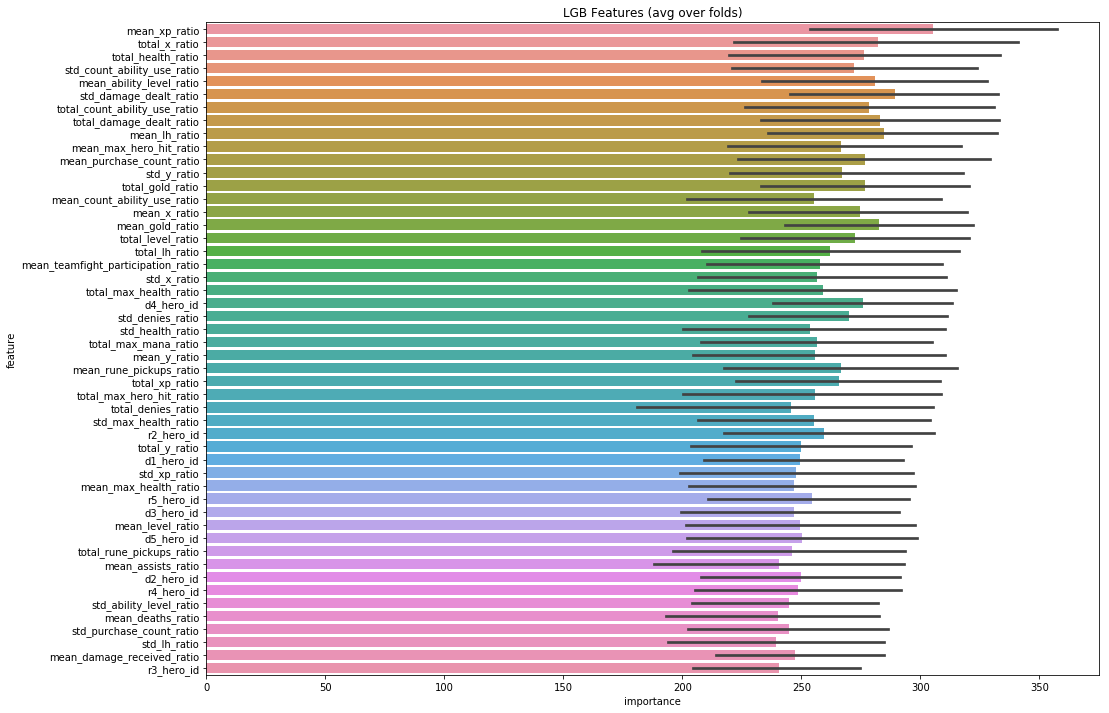

In [130]:
params = {'boost': 'gbdt',
          'feature_fraction': 0.05,
          'learning_rate': 0.01,
          'max_depth': -1,  
          'metric':'auc',
          'min_data_in_leaf': 50,
          'num_leaves': 32,
          'num_threads': -1,
          'verbosity': 1,
          'objective': 'binary'
         }



oof_lgb, prediction_lgb, scores = train_model(X_train, X_test, y_train, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [ ]:
sub = pd.read_csv('../input/sample_submission.csv')
sub['radiant_win_prob'] = prediction_lgb
sub.to_csv('submission.csv', index=False)
sub.head()